### Histogram of Oriented Gradients (HOG)

#### Question 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

**Answer** -

1: First of All I loaded all the images from vehicle and non vehicle dataset provided in the project links.


Shape of Vehicle Image(64, 64, 3)
Shape of Non Vehicle Image(64, 64, 3)


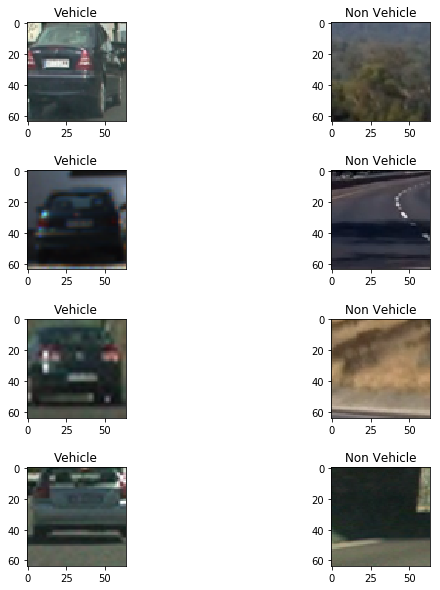

2: The code for extracting the hog features is mentioned in the function ```GetFeaturesFromHog```. This function returns two things (hog_features, hog_image) if visualisation is set to true else this function returns only hog_features. 

** An important thing to note here**

> No of hog_features != len(hog_image.ravel())

This is so because internally HOG optimizes the features vector before returing them, reducing the redundant data but image.ravel() basically stacks all the pixels together.



In [9]:

def GetFeaturesFromHog(image,orient,cellsPerBlock,pixelsPerCell, visualise= False, feature_vector_flag=True):
    if(visualise==True):
        hog_features, hog_image = hog(image, orientations=orient,
                          pixels_per_cell=(pixelsPerCell, pixelsPerCell), 
                          cells_per_block=(cellsPerBlock, cellsPerBlock), 
                          visualise=True, feature_vector=feature_vector_flag)
        return hog_features, hog_image
    else:
        hog_features = hog(image, orientations=orient,
                          pixels_per_cell=(pixelsPerCell, pixelsPerCell), 
                          cells_per_block=(cellsPerBlock, cellsPerBlock), 
                          visualise=False, feature_vector=feature_vector_flag)
        return hog_features

Feature Vector Length Returned is  1764
No of features that can be extracted from image  4096


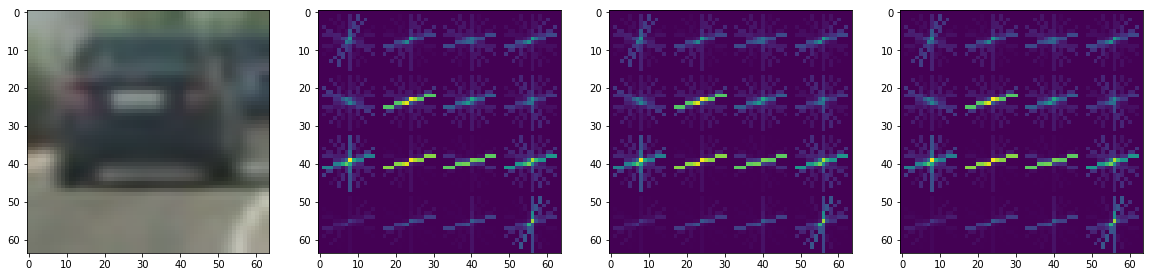

3: The HOG function expects a single channel image. So I defined a method ```ExtractFeatures``` which calls the function ```GetFeaturesFromHog``` and stacks all the features returned from different color channels

In [130]:

def ExtractFeatures(images,orientation,cellsPerBlock,pixelsPerCell, convertColorspace=False):
    featureList=[]
    imageList=[]
    for image in images:
        if(convertColorspace==True):
            image= cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        local_features_1=GetFeaturesFromHog(image[:,:,0],orientation,cellsPerBlock,pixelsPerCell, False, True)
        local_features_2=GetFeaturesFromHog(image[:,:,1],orientation,cellsPerBlock,pixelsPerCell, False, True)
        local_features_3=GetFeaturesFromHog(image[:,:,2],orientation,cellsPerBlock,pixelsPerCell, False, True)
        x=np.hstack((local_features_1,local_features_2,local_features_3))
        featureList.append(x)
    return featureList

#### Question 2. Explain how you settled on your final choice of HOG parameters.

**Answer**: There are a number of parameters that a HOG function expects. Below were my final chosen parameters 

| Parameter       | Value |
|-----------------|-------|
| Orientations    | 9     |
| Cells Per Block | 2     |
| Pixels Per Cell | 16    |
| Color Space     | YUV   |

I tried the following Combinations for extracting features.  Initially it was taking around half an hour to extract the features, then I realized the mistake I did was that I kept visualize to true due to which HOG was taking a lot of time, then I realized I just need the feature vectors and then it took only 45 seconds to extract the features. **My final choice was based on the outcome of my classifier accuracy and feature extraction time.**

| S. No | Orientations | Cells Per Block | Pixels Per Cell | Color Space | HOG Channel |
|-------|--------------|-----------------|-----------------|-------------|-------------|
| 1     | 9            | 2               | 8               | LUV         | ALL         |
| 2     | 9            | 2               | 8               | HSV         | 1,2         |
| 3     | 11           | 2               | 16              | HSL         | 1           |
| 4     | 6            | 4               | 16              | YUV         | 1           |
| 5     | 12           | 4               | 16              | YCrCb       | ALL         |
| 6     | 9            | 4               | 8               | YCrCb       | ALL         |
| 7     | 9            | 2               | 16              | YCrCb       | 2           |
| 8     | 11           | 2               | 8               | YUV         | ALL         |
| 9     | 9            | 2               | 16              | YUV         | ALL         |
| 10    | 9            | 2               | 8               | LUV         | 1           |
| 11    | 9            | 4               | 16              | LUV         | ALL         |
| 12    | 11           | 2               | 8               | LUV         | ALL         |
| 13    | 11           | 2               | 16              | LUV         | ALL         |



After Extracting all the features from vehicle and non vehicle images, I created the final feature set by stacking them together and then created the final labels by stacking ones equal to length of vehicle data and stacking zeros equal to length of non vehicle data

In [14]:
featuresList= np.vstack([vehicleFeatures, nonVehicleFeatures])
labelList= np.concatenate([np.ones(len(vehicleFeatures)), np.zeros(len(nonVehicleFeatures))])

Shape of features list is  (17760, 972)
Shape of label list is  (17760,)


#### Question 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

**Answer**: 

After stacking all the features extracted from vehicle and non vehicle dataset, the next part is to train the classifier. **I decided to use only HOG features and neither spatial bins nor color histograms were used to extract features**. But before training there are a lot of data preprocessing steps that were performed-

1: Splitting of Data into Training and Test Set- Data was splitted into training and test set to combact overfitting and test our model on test set. Also before splitting it was made sure that the data is properly shuffled


In [15]:
from sklearn.model_selection import train_test_split
X_train,  X_test,Y_train, Y_test = train_test_split(featuresList, labelList, test_size=0.2, shuffle=True)

2: Normalization and Scaling of Data- Data was normalized using Standard Scaler function of Sklearn.preprocessing class. **An important point to note here is that we do not fit the test set because by doing so we already give our classifier a sneek peak into data** 

In [16]:

from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
scaler.fit(X_train)
X_train_scaled= scaler.transform(X_train)
X_test_scaled= scaler.transform(X_test)

3: The final step is to train the classifier. I used LinearSVC with default parameteres. I used here SVC with 'rbf' kernel but the training was too slow, it was taking somewhere around 5 to 10 minutes to train. So I decided to use LinearSVC instead.

I was able to achieve a test accuracy of 98.7 % and that too in less than 2 seconds!! Well that was really very fast!

In [136]:
from sklearn.svm import LinearSVC
classifier1= LinearSVC()
classifier1.fit(X_train,Y_train)
print("Accuracy of SVC is  ", classifier1.score(X_test,Y_test) )

Accuracy of SVC is   0.9878941441441441
Wall time: 1.28 s


---

### Sliding Window Search

#### Question 1. Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?

**Answer:**

I implemented the sliding window searh in method ``` slide_window ```. This method returns the windows list. I decided to use the following windows after some hit and trials. The basic points to note here are-:

i) The cars will be basically in the lower half of the image so the we will search only in the lower half of the image.

ii) The cars near the chosen horizon will be small and will increase in size as we move from the horizon towards the car.

iii) It makes sense to search for 64x64 car in only one window starting from horizon and increase the window size as we move from horizon towards car. 

iv) For Windows of different sizes  we need to resize the window back to 64x64 because while training the classifier we trained on features extracted from 64x64 image.

v) The overlap selected was based on the fact that all possible points were covered. I searched for one bar of 64x64 window size near the horizon with more overlapping(85%) windows. Then I decided to search for one bar of 80x80 window size near the horizon with overlapping of 80%.

vi) There were a lot of false positives when I was using more windows. Intitally I was searching for all 

The final windows selected were-

| Window Size | Overlap | Y Start | Y Stop |
|-------------|---------|---------|--------|
| 64x64       | 85      | 400     | 464    |
| 80x80       | 80      | 400     | 480    |
| 96x96       | 70      | 400     | 612    |
| 128x128     | 50      | 400     | 660    |

In [20]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.9, 0.9)):
   
    if x_start_stop[0] == None:
        x_start_stop[0]=0
    if x_start_stop[1] == None:
        x_start_stop[1]=img.shape[1]
    if y_start_stop[0] ==  None:
        y_start_stop[0]= 0
    if y_start_stop[1] ==  None:
        y_start_stop[1]=img.shape[0]
    
    
    window_list = []
    image_width_x= x_start_stop[1] - x_start_stop[0]
    image_width_y= y_start_stop[1] - y_start_stop[0]
     
    windows_x = np.int( 1 + (image_width_x - xy_window[0])/(xy_window[0] * xy_overlap[0]))
    windows_y = np.int( 1 + (image_width_y - xy_window[1])/(xy_window[1] * xy_overlap[1]))
    
    modified_window_size= xy_window
    for i in range(0,windows_y):
        y_start = y_start_stop[0] + np.int( i * modified_window_size[1] * xy_overlap[1])
        for j in range(0,windows_x):
            x_start = x_start_stop[0] + np.int( j * modified_window_size[0] * xy_overlap[0])
            
            x1 = np.int( x_start +  modified_window_size[0])
            y1= np.int( y_start + modified_window_size[1])
            window_list.append(((x_start,y_start),(x1,y1)))
    return window_list 

In [21]:
# function that returns the refined Windows
# From Refined Windows we mean that the windows where the classifier predicts the output to be a car
def DrawCars(image,windows, converColorspace=False):
    refinedWindows=[]
    for window in windows:
        
        start= window[0]
        end= window[1]
        clippedImage=image[start[1]:end[1], start[0]:end[0]]
        
        if(clippedImage.shape[1] == clippedImage.shape[0] and clippedImage.shape[1]!=0):
            
            clippedImage=cv2.resize(clippedImage, (64,64))
            
            f1=ExtractFeatures([clippedImage], 9 , 2 , 16,converColorspace)
        
            predictedOutput=classifier1.predict([f1[0]])
            if(predictedOutput==1):
                refinedWindows.append(window)
        
    return refinedWindows

**The total number of windows I got were 470. Below is the image for coverage of windows, i.e. the area where the code will be searching for windows**

Total No of windows are  470


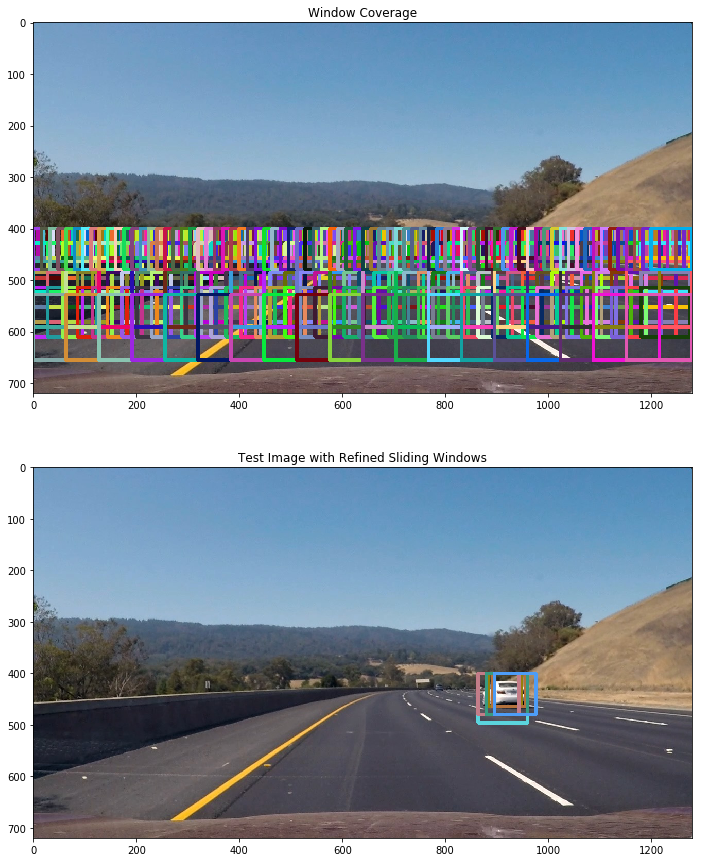

Once I was able to detect the car by using Sliding Window approach. The next I decided to use a heatup to plot the final bounding boxes around the car. I defined a function ```add_heat``` that increments the pixel value of an black image the size of the original image at the location of each detected window which I call as refined Window.

In [25]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap 

The next step was to remove the false positives. I used an averaging approach in the video pipeline that sums all the heats coming in the past 15 frames and then I apply threshold using the function ```apply_threshold```. This function blacks out the pixels who have value less than threshold value

In [1]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

Finally the next point is to draw bounding boxes on the final image. The scipy.ndimage.measurements.label() function collects spatially contiguous areas of the heatmap and assigns each a label:

In [27]:
from scipy.ndimage.measurements import label
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

 Number of Cars found -  1


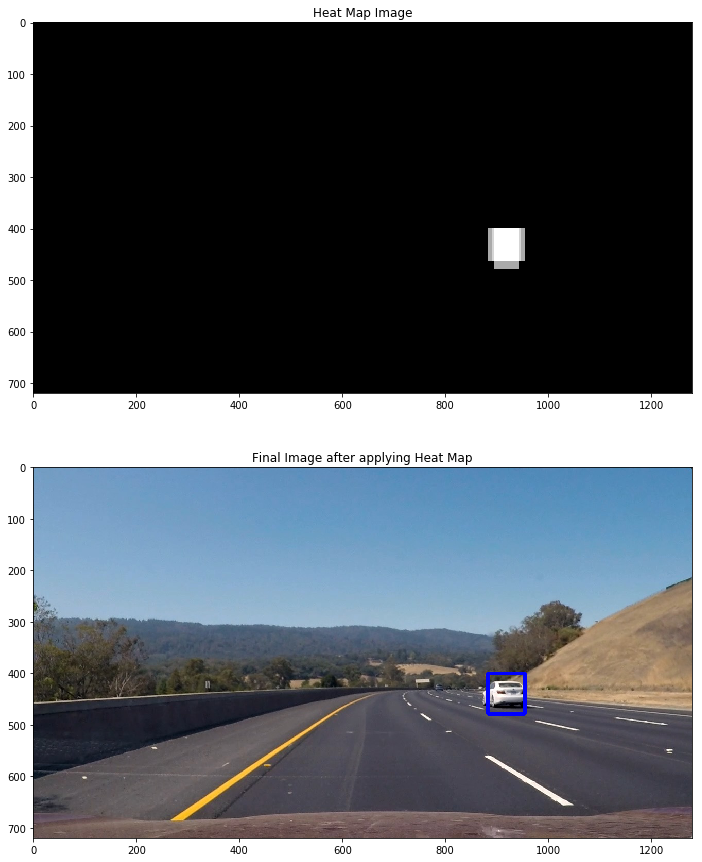

**Question 2: Show some examples of test images to demonstrate how your pipeline is working. What did you do to optimize the performance of your classifier?**

**Answer**:

**Please Note**- 

In this python notebook, I have defined two pipelines-:

i) ```Pipeline``` -> This pipeline is for the processing of video frames because here I need to take in account the summing and averaging code

ii) ```PiplineImage``` -> This pipeline is for the processing of test images. Here we do not have to take in count the averaging part.

Running the pipeline for test images gives the result as follows-:

Wall time: 8.1 s


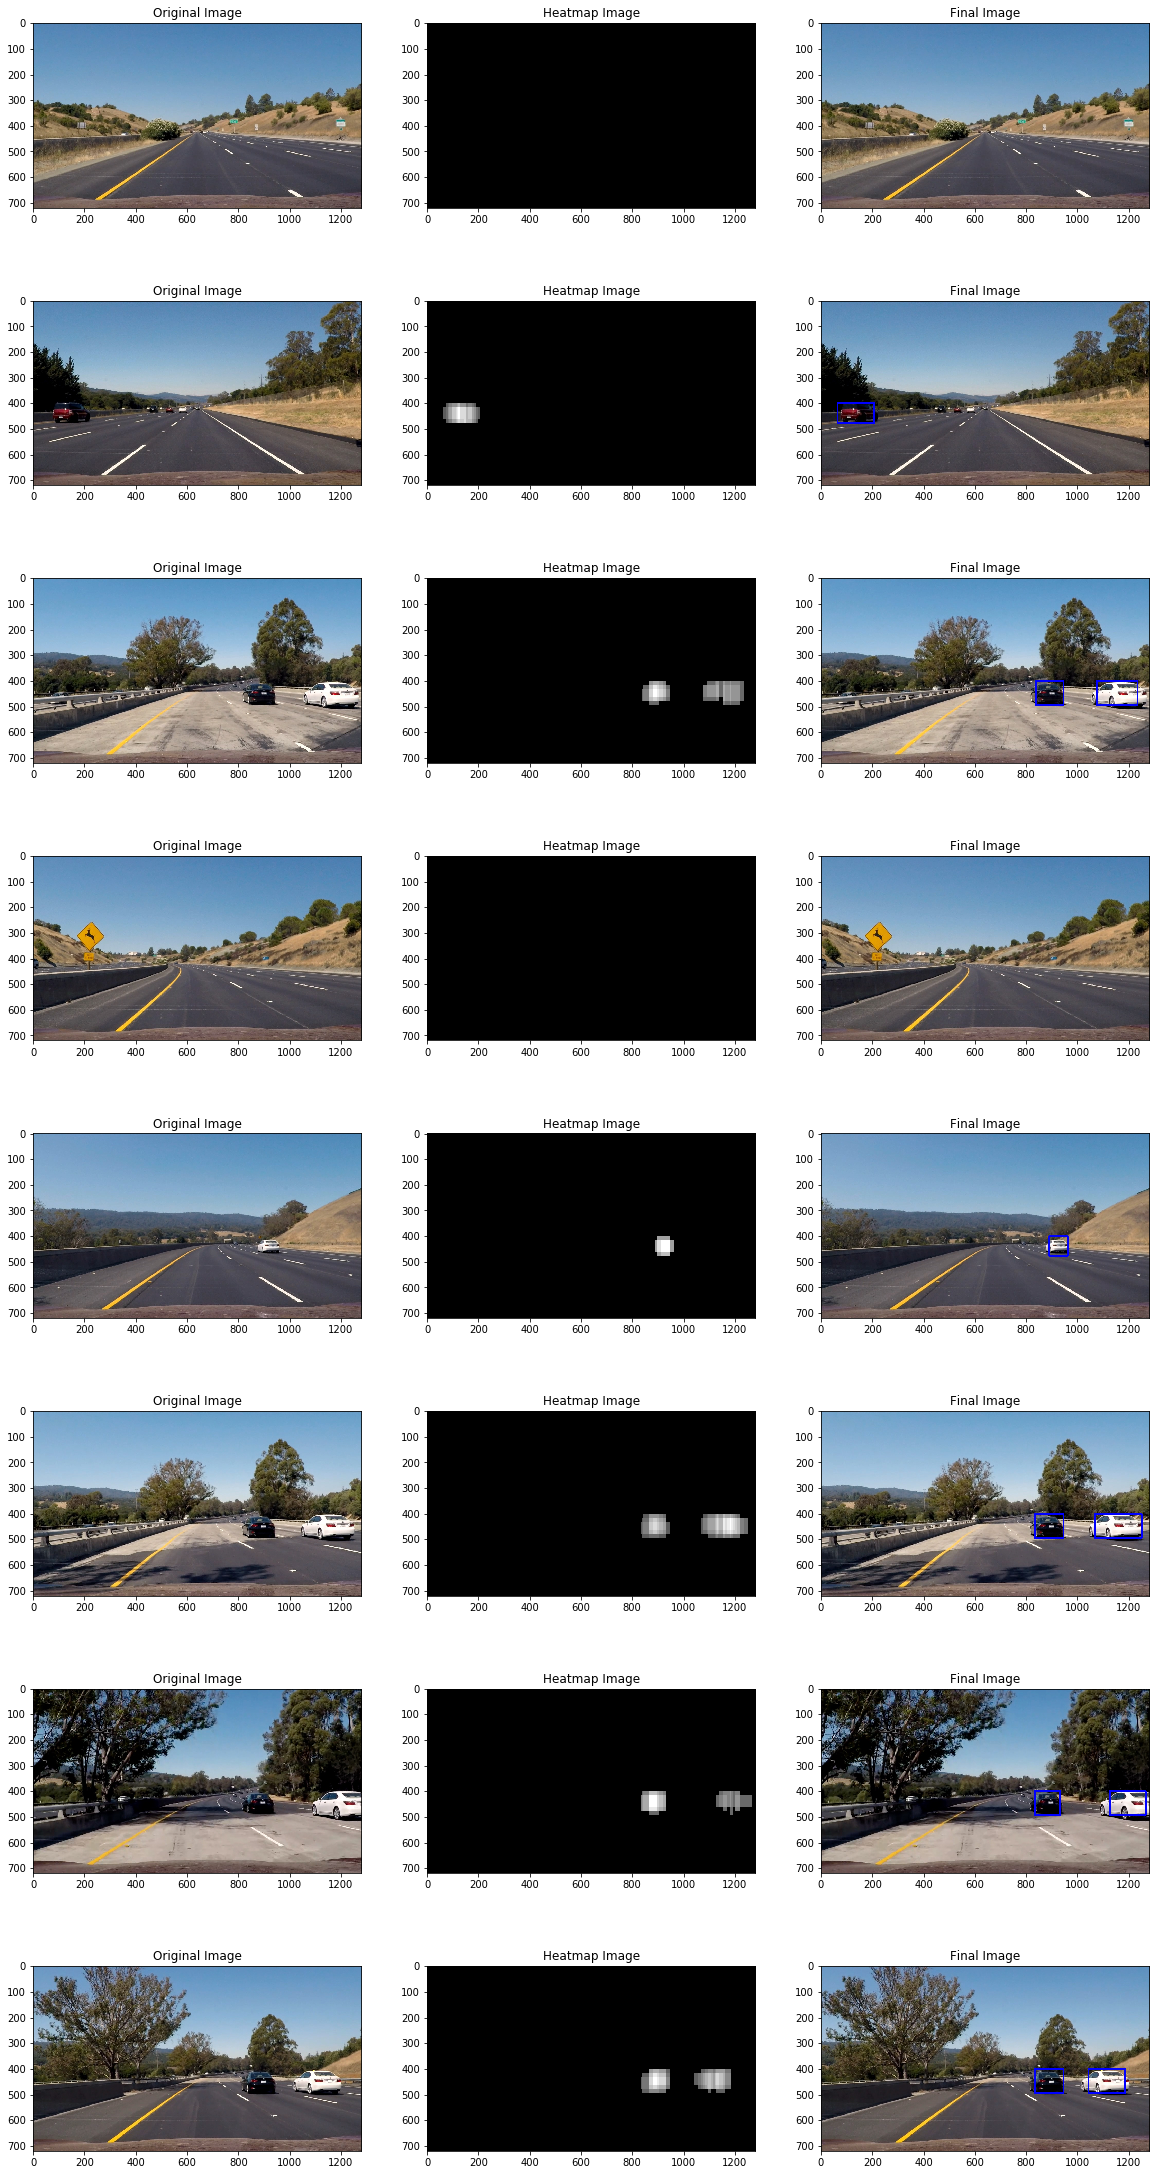

The final implentation worked well as it is clear from the test images. Nearly in all the images the cars were detected with ease. I decided to run the code then on video Pipeline.

#### False Positives-

There were a number of false positives that were detected  by the classifier when I ran it over the video but in the test_images it was sort of OK. I just tweeked the threshold to more so as to remove the false positives detected on the left lane or the tree. My classifier accuracy is around 98.7 so I was expecting some false positives in frames but using the correct threshold and summing up the heatmap refined windows solved my problem. In my window pipleline I have taken a dynamic threshold varying on the length of the previous detected refined windows.

**There was another approach, I decided to Skip frames at random to reduce the false positives about which I will talk later**

---
### Video Implementation

#### Question 1- Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

**Answer**:

Here's a [link to my video result](./project_video_output.mp4)


#### Question 2- Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

**Answer**:

As I discussed above the Pipeline for Video processing is defined in ```Pipeline``` function. In this function I am doing the exact same thing I am doing in Image pipeline except the fact that in this code I am storing previous refined windows in a class called KeepTrack. After doing a lot of hit and trials, I finally changed my threshold to ```25 + len(windows)/2```. This was done to remove the false positives detected on the left half of the window. 

I recorded the positions of positive detections in each frame of the video. From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions. I then used ```scipy.ndimage.measurements.label()``` to identify individual blobs in the heatmap. I then assumed each blob corresponded to a vehicle. I constructed bounding boxes to cover the area of each blob detected.

For Combining Bounding Boxes I have already discussed above I am using heatmap for that. ```draw_labeled_bboxes``` is the function that has the responsibility to draw the final bounding boxes

In [189]:
def Pipeline(image):
    rand= random.randint(0,1)
    if(rand<0.4):
        refinedWindows=keepTrack.refinedWindows[:-1]
    else:
        refinedWindows=DrawCars(image,windows, True)
        if len(refinedWindows) > 0:
            keepTrack.AddWindows(refinedWindows)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    for refinedWindow in keepTrack.refinedWindows:
        heat = add_heat(heat, refinedWindow)
    
    heatmap = apply_threshold(heat, 25 + len(keepTrack.refinedWindows)//2)
    
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

In [160]:
# Defining a class to store the refined frames found from the last 15 frames

class KeepTrack():
    def __init__(self):
        self.refinedWindows = [] 
        
    def AddWindows(self, refinedWindow):
        self.refinedWindows.append(refinedWindow)
        frameHistory=15
        if len(self.refinedWindows) > frameHistory:
            self.refinedWindows = self.refinedWindows[len(self.refinedWindows)-frameHistory:]


---

### Discussion

**1. Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?**

**Answer**-

**Please Read this without fail**

1: I suffered a lot implenting the pipeline of the project due to some silly mistakes. I took variable size windows but I applied all sizes windows to almost the complete lower half which is wrong as I explained that you are bound to get 64px car near the horizon only and not near to dashboard. So as a result my resulting windows were around 5500, due to which the final video pipeline took around 4 hours to build.


2: I realized my mistake and immediately took an action and reduced the window size to 1500. Then I realized that my overlap was kind of 90% in every window size that was too much to handle. So I took varying overlapping sizes according to the size of windows.


3: I tried HOG subsampling to make the pipeline faster but the problem was I was not able to extract features correctly as my trained features in the classifier were 972 but in HOG subsampling they were just 27. ```DrawCarsOptimised``` is the function if you intend to see the code for subsampling.


4: I was able to reduce my window size to 470 but then came a new problem of false positives. But not to worry keeping the thresholds correct and summing and averaging helped me a lot to make smooth bounding boxes.


5: **I earlier talked about frame skipping strategy. What I did was to take a random number between 0 and 1, if the value of number taken was less than 0.4 then I skipped the frame and took the refined windows from the previous stored frames. This decreased the processing time of my pipeline as well.** I was able to create a video from 4 hours to 4 minutes using all the methods above.

 Here's a [link to the video result](./project_video_output_with_frame_skipping.mp4)
 
 Here's another [link to the video result](./project_video_output_with_frame_skipping_threshold_20.mp4)
 


6: **I have included all my generated Videos in the Drafts Folder. I have tried to name properly but they are a perfect record of the struggle involved in the project**. I have included Python notebooks as well in the Drafts Folder. 
